## Machine Learning-based LiDAR Feature Extraction

This notebook will show how this experimental ML-based LiDAR soluion can directly classifiy points into the meaningful features such as building, tree, ground, etc. The workflow of the solution consists of the following steps:

(1) Convert `.las` file to `.ply` file

(2) Compute seven pre-defined point-characteristics (i.e., "height above ground", "planarity", "sphericity", "verticality", "anisotropy", "surface variation", and "intensity") for all the points

(3) Classify the points based on their calculated point-characteristics using a pre-trained Bidirectional Long Short-Term Memory (BiLSTM) model.


**IMPORTANT NOTE:** All essential code in`configs` folder and `external.py` are from [aerial_pc_classification](https://github.com/theobdt/aerial_pc_classification) project. The purpose of integrating this source is to explore this state-of-the-art end-to-end solution to directly extract features from LiDAR. <font color='red'>. However, the model here does not support `.las` file. A data adapter, along with the needed code integration and consolidation were implemented to serve the feature extract purpose.</font>

## Important Setup
The notebook depends on some external modules. Please make sure to following the instructions in README.md to set up the conda environment and activate it before launching this notebook. A sample LiDAR dataset [C_37EZ2_7415_sample.las](data/mlbase/C_37EZ2_7415_sample.las) is provided for this notebook. 

Note: You may want to use the GPU if intend to run the this notebook to process LiDAR data that covers a large area. That requires you to install PyTorch along with CUDA ToolKit by running `conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch`.

## Required Modules

In [1]:
# external modules
import laspy
import os
import numpy as np
from IPython.display import Image

# customized modules
from lidar2feature import utils, mlbase, external

## Data
A sample LiDAR dataset [C_37EZ2_7415_sample.las](data/mlbase/C_37EZ2_7415_sample.las) is provided for this notebook. You can run this notebook on other `.las` datasets by changing the `las_name` below.

In [2]:
# the name of the processing data
las_name = 'C_37EZ2_7415_sample.las'

# the file path for the input data and prefix
data_dir = './data/mlbase/'
os.makedirs(data_dir, exist_ok=True)
input_las_path = data_dir + las_name
las_prefix = data_dir + os.path.splitext(las_name)[0]

## 1. Convert the targeted `.las` file to `.ply` data in order to feed in the trained model 

In [3]:
# convert the .las data to .ply data
ply_path = utils.las_to_ply(input_las_path, las_prefix)

Completed converting the point cloud and saved them to ./data/mlbase/C_37EZ2_7415_sample.ply


## 2. Computer characteristics of the target file
The seven pre-defined point-characteristics: "height above ground", "planarity", "sphericity", "verticality", "anisotropy", "surface variation", and "intensity."

In [4]:
# compute the pre-defined point-characteristics
ply_path = external.compute_characteristics(ply_path, las_prefix)

This process can take time when processing a large .las file ... 

Computing local descriptors ...
* descriptors: ['normals', 'verticality', 'linearity', 'planarity', 'sphericity', 'curvature', 'anisotropy', 'surface_variation']
* radius: 2
* epsilon: 0.01
* preferred normals orientation: +z
* querying radius ...


* Processing neighborhoods: 100%|██████████| 456941/456941 [00:26<00:00, 16997.95it/s]



Computing regions ...
* descriptor selected : max planarity
* thresholds : {'height': 0.1, 'angle': 0.1, 'descriptor': 0.1}
* radius : 1
* number of valid regions grown : 201

Extracting ground from regions ...


* Computing intra slopes: 100%|██████████| 200/200 [00:00<00:00, 1156.09it/s]
E:\WPHChallenge\11_HomeRun\lidar2feature\external.py:939: RuntimeWarning: invalid value encountered in true_divide
  slopes_intra = heights / spans
* Stitching regions together: 100%|██████████| 200/200 [00:06<00:00, 32.53it/s]


* PLY ground file successfully saved to ./data/mlbase/C_37EZ2_7415_sample_ground_only.ply

Computing ground rasterization ...
* method : delaunay
* step_size : 0.5
* Completed the ground rasterized file and saved to ./data/mlbase/C_37EZ2_7415_sample_ground_rasterized.ply

Computing height above ground ...

Completed comptuing the characteristics and saved to ./data/mlbase/C_37EZ2_7415_sample_features.ply


## 3. Classify the class of each point of the input `.las` file

In [5]:
# classify the class of all points and save them in a .ply file
ply_path = mlbase.classification(ply_path, las_prefix)

Recommend to install the CUDA toolkit to run the model on GPU if you intend to process a large dataset ... 
* device in use : cpu
* trained model ./configs/trained_model ...
* number of classes: 9

Loading model ...

Processing file: ./data/mlbase/C_37EZ2_7415_sample_features.ply ...

Preparing dataloader ...

* total number of points: 456941


* Processing point cloud: 100%|██████████| 457/457 [07:57<00:00,  1.05s/it]


Completed classifying all points and stored them at ./data/mlbase/C_37EZ2_7415_sample_result.ply ...


## Visualize the results
I cannot find a package to visualize this resulting `.ply` file with customized variable (called predictions). So instead, I used the CloudCompare software to show how what the result look like. The following two pictures show the before- and after- classification using the provided [C_37EZ2_7415_sample.las](data/mlbase/C_37EZ2_7415_sample.las). 

The picture below is a 3D visualization of the provided data where tree points (appear to be BLUE) are unassigned.


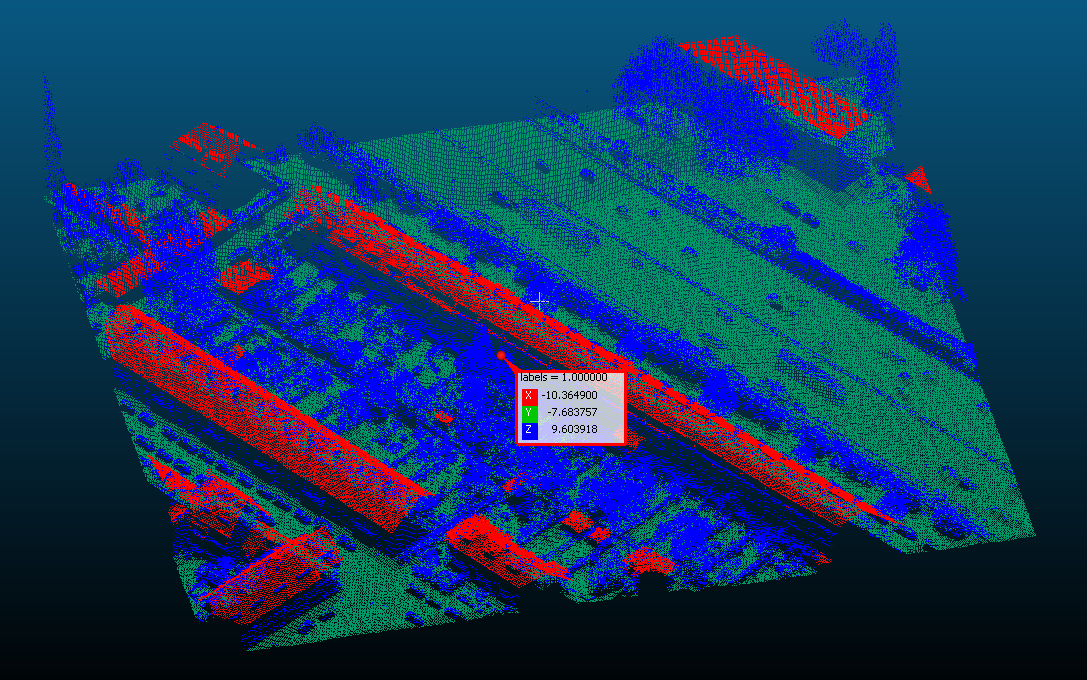

In [6]:
print("The picture below is a 3D visualization of the provided data where tree points (appear to be BLUE) are unassigned.")
Image(filename='pictures/ply_before_ml.png') 

The picture below shows the predicted results of the provided data. Most of the tree points (which appear to be RED) were correctly identified and extracted.


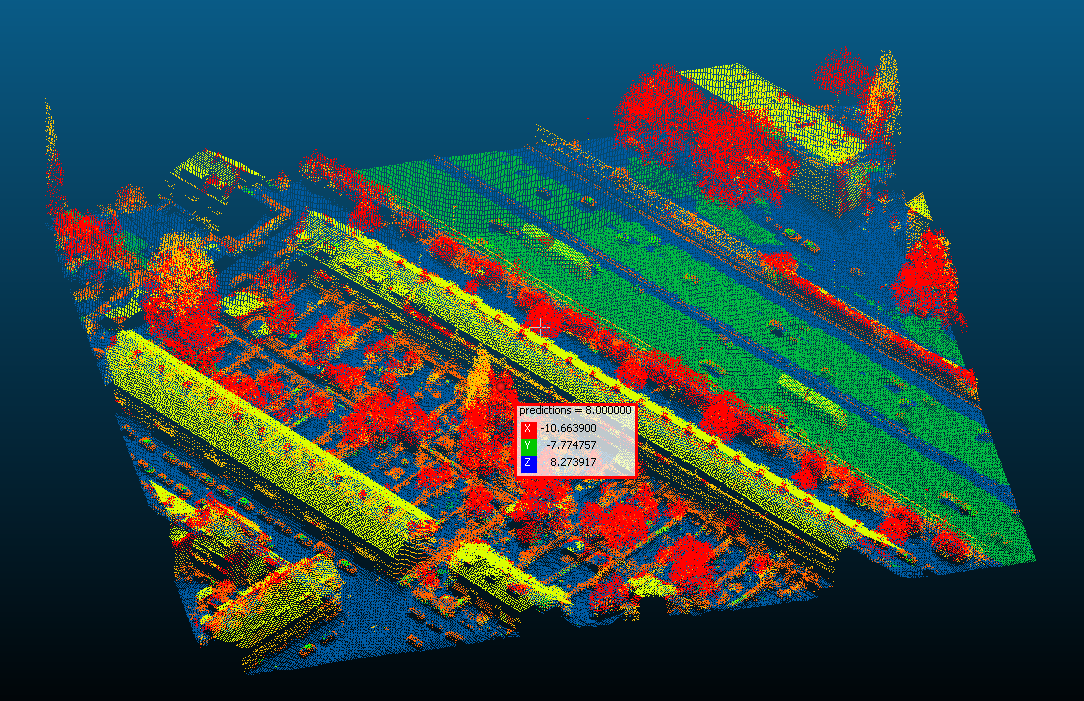

In [7]:
print("The picture below shows the predicted results of the provided data. Most of the tree points (which appear to be RED) were correctly identified and extracted.")
Image(filename='pictures/ply_after_ml.png') 